In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import numpy
import torch
from time import time
from tqdm import tqdm

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
cwd = os.getcwd()
NOTEBOOK_DIR = os.path.dirname(cwd+'/')
ROOT = os.path.dirname(NOTEBOOK_DIR)

import sys
sys.path.append(ROOT)

In [4]:
from utils.tools import *

# Constants

In [5]:
INPUT_DIM = 10 #50
BIAS = False

SEED = 42
N_TRAIN = 256
BATCH_SIZE = 64
ALPHA = 1e-1
BASE_LR = 1.0e-2
N_STEPS = int(1.5e3)
N_VAL = 100
VAL_ITER = 100
N_MAX_NEURONS = 2000

EPS = 1.0e-7
ALPHA = 1.0
BETA = 1.0
LAMBDA = 0.02

In [6]:
FIGURES_DIR = os.path.join(ROOT, 'figures/kernel_penalty/')
create_dir(FIGURES_DIR)

In [7]:
set_random_seeds(SEED)

## Common functions

In [8]:
def H(a, b, sigma=1.0):
    deltas = b.reshape(m, 1, INPUT_DIM) - b
    K = np.exp(-np.sum(deltas**2, axis=-1) / (2 * sigma**2))
    return 0.5 * np.matmul(a.T, np.matmul(K, a))

In [9]:
def grad_a_H(a, b, sigma=1.0):
    deltas = b.reshape(m, 1, INPUT_DIM) - b
    K = np.exp(-np.sum(deltas**2, axis=-1) / (2 * sigma**2))
    return np.matmul(K, a)

In [10]:
def grad_b_H(a, b, sigma=1.0):
    deltas = b.reshape(m, 1, INPUT_DIM) - b
    outer = np.matmul(a, a.T).reshape(m, m, 1)
    K = np.exp(-np.sum(deltas**2, axis=-1) / (2 * sigma**2))
    return np.sum(outer * deltas * K.reshape(m, m, 1), axis=0) / sigma**2

In [11]:
def train(sigma=1.0):
    a = np.sign(np.random.normal(size=(m, 1)))
    #a = np.ones(shape=(m, 1))
    b = np.random.uniform(low=0.0, high=1.0, size=(m, INPUT_DIM))
    
    as_ = [a]
    bs = [b]
    losses = []
    
    for k in range(N_STEPS):
        a = a + ETA * grad_a_H(a, b, sigma)
        b = b + ETA * grad_b_H(a, b, sigma)
        loss = -H(a, b)[0, 0]
        
        as_.append(a)
        bs.append(b)
        losses.append(loss)
        
    return np.array(as_), np.array(bs), np.array(losses)

In [12]:
m = 30
INPUT_DIM = 1
ETA = 0.0005
sigma = 0.04
N_STEPS = 800

a, b, losses = train(sigma=sigma)

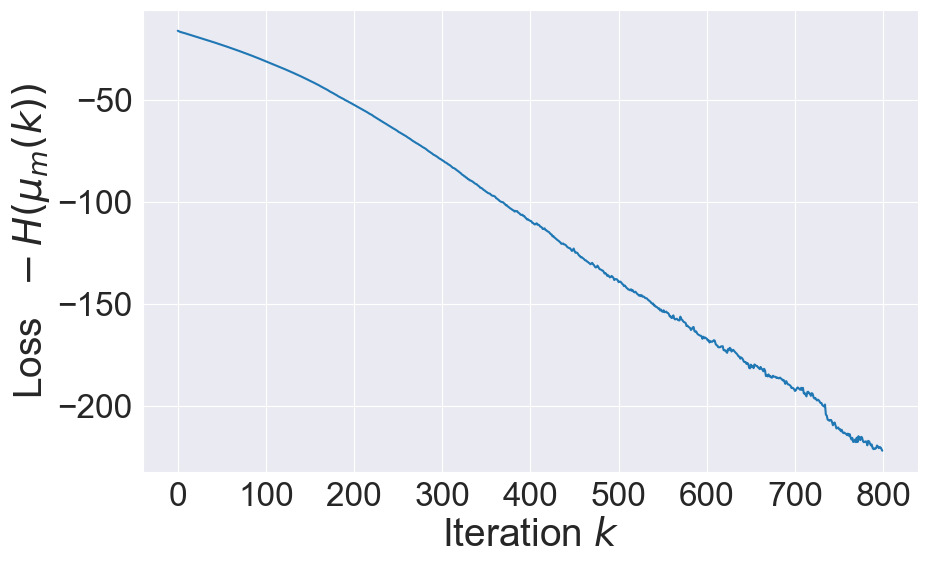

In [13]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(losses)), losses)

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Loss $\\ -H(\\mu_m(k))$', fontsize=28)
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

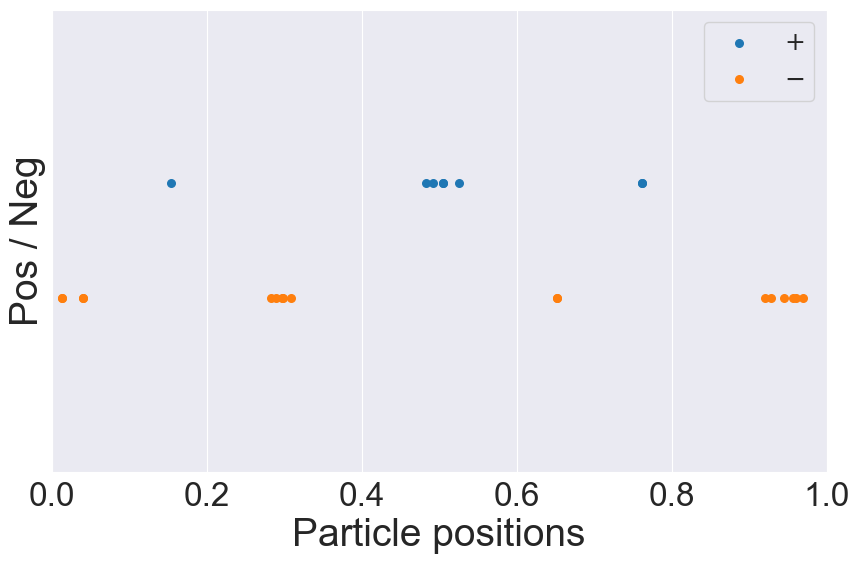

In [14]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')
marker = 'o'

signs = a[0, :, 0]
pos = (signs > 0)
neg = (signs < 0)
b_pos = b[:, pos, :]
b_neg = b[:, neg, :]
k = 300

plt.xlim(0, 1)
plt.ylim(-2, 2)

plt.scatter(b_pos[k, :, 0], 0.5*np.ones(len(b_pos[k, :, 0])), marker=marker, s=30.0, label='$+$')
plt.scatter(b_neg[k, :, 0], -0.5*np.ones(len(b_neg[k, :, 0])), marker=marker, s=30.0, label='$-$')

plt.xlabel('Particle positions', fontsize=28)
plt.ylabel('Pos / Neg', fontsize=28)
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks([])
#plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

In [15]:
marker = 'o'
signs = a[0, :, 0]
pos = (signs > 0)
neg = (signs < 0)
b_pos = b[:, pos, :]
b_neg = b[:, neg, :]

for k in range(len(b)):
    plt.figure(figsize=(10, 6))


    plt.scatter(b_pos[k, :, 0], np.ones(len(b_pos[k, :, 0])), marker=marker, s=40.0, label='$+$')
    plt.scatter(b_neg[k, :, 0], -np.ones(len(b_neg[k, :, 0])), marker=marker, s=40.0, label='$-$')
    
    plt.xlim(0, 1)
    plt.ylim(-2, 2)

    plt.xlabel('Particle positions', fontsize=28)
    plt.ylabel('Pos / Neg', fontsize=28)
    plt.xticks(fontsize=24)
    plt.yticks([])
    plt.legend(fontsize=18, loc='center right')
    plt.savefig(os.path.join(FIGURES_DIR, 'attraction-repulsion_{}.png'.format(k)), bbox_inches='tight')
    plt.close()

In [16]:
a_pos = a[:, pos, 0]
a_neg = a[:, neg, 0]

In [17]:
a_pos

array([[1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.00083754, 0.9994993 , 1.00074394, ..., 1.00042328, 1.00006621,
        1.00047075],
       [1.00175643, 0.99912821, 1.00188253, ..., 1.00109064, 1.00072115,
        1.00148555],
       ...,
       [2.09344272, 2.14341173, 3.41465239, ..., 3.44557612, 3.43292364,
        3.48329239],
       [2.09518356, 2.14513302, 3.41799042, ..., 3.44715546, 3.43653483,
        3.48695527],
       [2.09688526, 2.14698517, 3.42240187, ..., 3.44888072, 3.44120822,
        3.49242806]])

In [18]:
a_pos.shape

(801, 12)